# Download dataset

In [1]:
!kaggle competitions download -c house-prices-advanced-regression-techniques
import zipfile
with zipfile.ZipFile("house-prices-advanced-regression-techniques.zip","r") as zip_f:
    zip_f.extractall("input")

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


# Important imports


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
import numpy as np
import pandas as pd

import catboost
import catboost.datasets
import shap
import sklearn.model_selection

import matplotlib.pyplot as plt
# import plotly.express as px
import seaborn as sns

from scipy import stats
from catboost import CatBoostRegressor, Pool

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.feature_selection import RFECV

import plotly.express as px
import plotly.figure_factory as ff
import scipy.stats as stats
# import eli5
# from eli5.sklearn import PermutationImportance

# import hyperopt
from sklearn import preprocessing
from numpy.random import RandomState
from os import listdir

from catboost.eval.catboost_evaluation import *
from catboost.utils import create_cd

# import shap
# # load JS visualization code to notebook
# shap.initjs()

# Load dataset

## Train


In [3]:
train = pd.read_csv("input/train.csv", index_col=0)
min_max_scaler = preprocessing.MinMaxScaler()
train.head(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal     208500  
2        0      5    2007        WD         Normal     181500  
3        0      9    2008        WD         Normal     223500  
4        0      2    2006        WD        Abnorml     140000  
5        0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

## Test 


In [4]:
test = pd.read_csv("input/test.csv", index_col=0)
test.head(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1461          20       RH         80.0    11622   Pave   NaN      Reg   
1462          20       RL         81.0    14267   Pave   NaN      IR1   
1463          60       RL         74.0    13830   Pave   NaN      IR1   
1464          60       RL         78.0     9978   Pave   NaN      IR1   
1465         120       RL         43.0     5005   Pave   NaN      IR1   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
Id                                    ...                                      
1461         Lvl    AllPub    Inside  ...         120        0    NaN  MnPrv   
1462         Lvl    AllPub    Corner  ...           0        0    NaN    NaN   
1463         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   
1464         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
1465         HLS    AllPub    Inside  ...         144        0    NaN    NaN   

     MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                                 
1461         NaN       0       6    2010        WD         Normal  
1462        Gar2   12500       6    2010        WD         Normal  
1463         NaN       0       3    2010        WD         Normal  
1464         NaN       0       6    2010        WD         Normal  
1465         NaN       0       1    2010        WD         Normal  

[5 rows x 79 columns]

# data view 

output columns with a large number of missing values

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

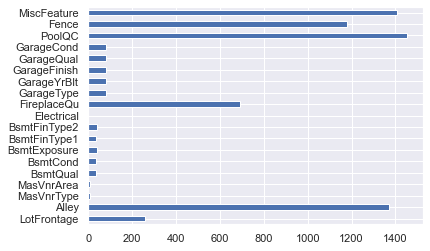

In [5]:
null_features = train.isnull().sum(axis = 0)
null_features[null_features>=1].plot(kind = 'barh')
null_features

заполнение пропущеных ибинаризация некоторых признаков значений согласно файлу описания data_description.txt

In [6]:
#check description to fill missings
train['Fence'] = train['Fence'].fillna('No Fence')
train['Fence'] = [1 if x != 'No Fence' else 0 for x in train.loc[:,'Fence'].values]

train['PoolQC'] = train['PoolQC'].fillna('No Pool')
train['PoolQC'] = [1 if x != 'No Pool' else 0 for x in train.loc[:,'PoolQC'].values]

train['MiscFeature'] = train['MiscFeature'].fillna('None')

train['FireplaceQu'] = train['FireplaceQu'].fillna('No Fireplace')
train['FireplaceQu'] = [1 if x != 'No Fireplace' else 0 for x in train.loc[:,'FireplaceQu'].values]

train['Fence'] = train['Fence'].fillna('No Fence')
train['Fence'] = [1 if x != 'No Fence' else 0 for x in train.loc[:,'Fence'].values]

train['Alley'] = train['Alley'].fillna('No alley access')
train['Alley'] = [1 if x != 'No alley access' else 0 for x in train.loc[:,'Alley'].values]

train['LotFrontage'] = train['LotFrontage'].fillna('0')

train['GarageType'] = train['GarageType'].fillna('No Garage')

train['GarageCond'] = train['GarageCond'].fillna('No Garage')

train['GarageQual'] = train['GarageQual'].fillna('No Garage')

train['GarageFinish'] = train['GarageFinish'].fillna('No Garage')

train['GarageYrBlt'] = train['GarageYrBlt'].fillna('No Garage')
train['GarageYrBlt'] = [1 if x != 'No Garage' else 0 for x in train.loc[:,'GarageYrBlt'].values]

train[ 'BsmtFinType1'] = train['BsmtFinType1'].fillna('No Basement')
train['BsmtFinType2'] = train['BsmtFinType2'].fillna('No Basement')

train['BsmtExposure'] = train['BsmtExposure'].fillna('No Basement')

train['BsmtCond'] = train['BsmtCond'].fillna('No Basement')

train['BsmtQual'] = train['BsmtQual'].fillna('No Basement')

train['MasVnrArea'] = train['MasVnrArea'].fillna('0')


train['MasVnrType'] = train['MasVnrType'].fillna('None')

train['Electrical'] = train['Electrical'].fillna('Mixed')


In [7]:
#check description to fill missings
test['Fence'] = test['Fence'].fillna('No Fence')
test['Fence'] = [1 if x != 'No Fence' else 0 for x in test.loc[:,'Fence'].values]

test['PoolQC'] = test['PoolQC'].fillna('No Pool')
test['PoolQC'] = [1 if x != 'No Pool' else 0 for x in test.loc[:,'PoolQC'].values]

test['MiscFeature'] = test['MiscFeature'].fillna('None')

test['FireplaceQu'] = test['FireplaceQu'].fillna('No Fireplace')
test['FireplaceQu'] = [1 if x != 'No Fireplace' else 0 for x in test.loc[:,'FireplaceQu'].values]

test['Fence'] = test['Fence'].fillna('No Fence')
test['Fence'] = [1 if x != 'No Fence' else 0 for x in test.loc[:,'Fence'].values]

test['Alley'] = test['Alley'].fillna('No alley access')
test['Alley'] = [1 if x != 'No alley access' else 0 for x in test.loc[:,'Alley'].values]

test['LotFrontage'] = test['LotFrontage'].fillna('0')

test['GarageType'] = test['GarageType'].fillna('No Garage')

test['GarageCond'] = test['GarageCond'].fillna('No Garage')

test['GarageQual'] = test['GarageQual'].fillna('No Garage')

test['GarageFinish'] = test['GarageFinish'].fillna('No Garage')

test['GarageYrBlt'] = test['GarageYrBlt'].fillna('No Garage')
test['GarageYrBlt'] = [1 if x != 'No Garage' else 0 for x in test.loc[:,'GarageYrBlt'].values]

test[ 'BsmtFinType1'] = test['BsmtFinType1'].fillna('No Basement')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('No Basement')

test['BsmtExposure'] = test['BsmtExposure'].fillna('No Basement')

test['BsmtCond'] = test['BsmtCond'].fillna('No Basement')

test['BsmtQual'] = test['BsmtQual'].fillna('No Basement')

test['MasVnrArea'] = test['MasVnrArea'].fillna('0')


test['MasVnrType'] = test['MasVnrType'].fillna('None')

test['Electrical'] = test['Electrical'].fillna('Mixed')

Проверка остались ли пустые значения в датасете?


In [8]:
null_features = train.isnull().sum(axis = 0)
if null_features[null_features == '0'].all():
    print('no null features')
else:
    null_features[null_features>=1].plot(kind = 'barh')
    null_features


no null features


### outliers

проверка на выбросы числовых небинарных фичей

['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


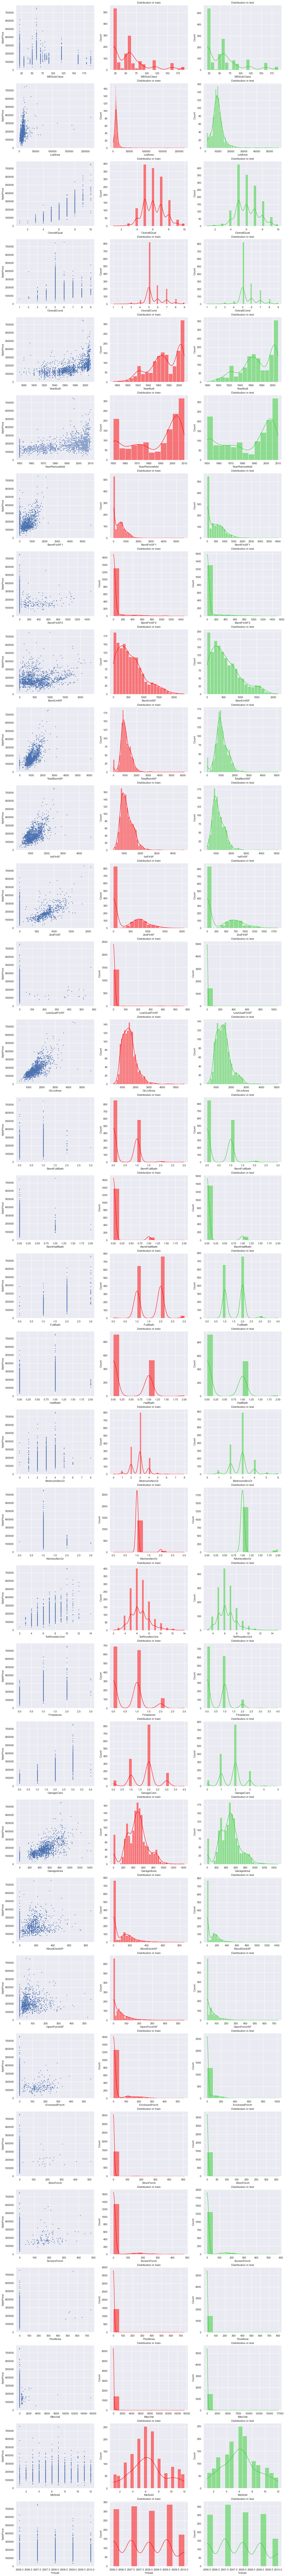

In [9]:
# numerical non binar features
num_features = list()
for col in train:
    if train[col].dtypes!="object" and train[col].nunique()>2:
          num_features.append(col)
num_features = num_features[:len(num_features)-1]
print(num_features)
fig, ax = plt.subplots(len(num_features),3,figsize=(20,len(num_features)*6))

for n in range(len(num_features)):
    feat = num_features[n]
    ax[n,0].scatter(train[feat].values, train.SalePrice.values, s=4)
    ax[n,0].set_ylabel("SalePrice")
    ax[n,0].set_xlabel(feat);
    sns.histplot(train[feat], kde=True, ax=ax[n,1], color="red")
    ax[n,1].set_title("Distribution in train")
    
    
    sns.histplot(test[feat], kde=True, ax=ax[n,2], color="limegreen")
    ax[n,2].set_title("Distribution in test")

In [10]:
import plotly.io as pio; pio.renderers.default='notebook'
fig = px.scatter(train, x='GrLivArea', y='SalePrice', color_discrete_sequence=px.colors.sequential.Rainbow)

fig.update_layout(height=600, width=800, title_text='GrLivArea/SalePrice')
fig.show()

In [11]:
train = train.drop(train.sort_values(by='GrLivArea', ascending=False)[:2].index)

In [12]:
fig = px.scatter(train, x='TotalBsmtSF', y='SalePrice', color_discrete_sequence=px.colors.sequential.Oryel_r)

fig.update_layout(height=600, width=800, title_text='TotalBsmtSF/SalePrice')
fig.show()

In [13]:
train = train.drop(train.sort_values(by='TotalBsmtSF', ascending=False)[:1].index)

### Sale Prise Distribution

Распределение цены

Text(0.5, 1.0, 'Target distribution in train')

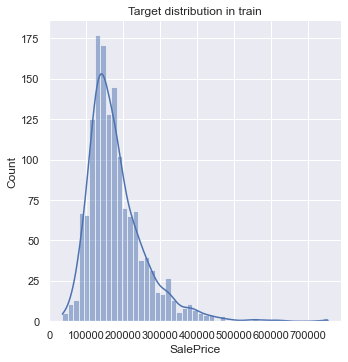

In [14]:
sns.set(rc={'figure.figsize':(50,25)})

sns.displot(train.SalePrice,kde=True)

plt.title("Target distribution in train")

применим функцию логарифма чтобы распределнение было больше похоже на нормальное

Text(0.5, 1.0, 'Log distribution in train')

<Figure size 1440x360 with 0 Axes>

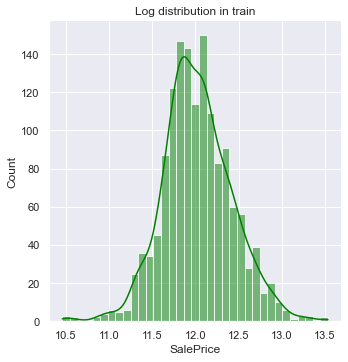

In [15]:
plt.figure(figsize=(20,5))
sns.displot(np.log(train.SalePrice), color="green", kde = True)
plt.title("Log distribution in train")

In [16]:
train["SalePrice"] = train.SalePrice.apply(np.log)

In [17]:
cat_features = list(train.select_dtypes(include='object').columns)
train[cat_features].describe().T.sort_values('unique', ascending=False)

count unique      top   freq
MasVnrArea     1457.0  325.0      0.0  861.0
LotFrontage      1457    111        0    259
Neighborhood     1457     25    NAmes    225
Exterior2nd      1457     16  VinylSd    503
Exterior1st      1457     15  VinylSd    514
SaleType         1457      9       WD   1266
Condition1       1457      9     Norm   1259
HouseStyle       1457      8   1Story    725
Condition2       1457      8     Norm   1443
RoofMatl         1457      7  CompShg   1432
BsmtFinType2     1457      7      Unf   1254
BsmtFinType1     1457      7      Unf    430
Functional       1457      7      Typ   1357
GarageType       1457      7   Attchd    868
RoofStyle        1457      6    Gable   1140
Electrical       1457      6    SBrkr   1331
GarageQual       1457      6       TA   1308
Heating          1457      6     GasA   1425
GarageCond       1457      6       TA   1323
Foundation       1457      6    PConc    644
SaleCondition    1457      6   Normal   1197
BsmtExposure     1457      5       No    952
HeatingQC        1457      5       Ex    738
MiscFeature      1457      5     None   1403
MSZoning         1457      5       RL   1148
BsmtCond         1457      5       TA   1308
BsmtQual         1457      5       TA    649
BldgType         1457      5     1Fam   1217
LotConfig        1457      5   Inside   1050
ExterCond        1457      5       TA   1279
ExterQual        1457      4       TA    906
MasVnrType       1457      4     None    872
KitchenQual      1457      4       TA    735
GarageFinish     1457      4      Unf    605
LandContour      1457      4      Lvl   1310
LotShape         1457      4      Reg    925
LandSlope        1457      3      Gtl   1379
PavedDrive       1457      3        Y   1337
CentralAir       1457      2        Y   1362
Utilities        1457      2   AllPub   1456
Street           1457      2     Pave   1451

выбор категориальныъ фичей для catboost


In [18]:
cat_features = list(train.columns[:len(train.columns)-1])
print(*cat_features)

MSSubClass MSZoning LotFrontage LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle OverallQual OverallCond YearBuilt YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinSF1 BsmtFinType2 BsmtFinSF2 BsmtUnfSF TotalBsmtSF Heating HeatingQC CentralAir Electrical 1stFlrSF 2ndFlrSF LowQualFinSF GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr KitchenQual TotRmsAbvGrd Functional Fireplaces FireplaceQu GarageType GarageYrBlt GarageFinish GarageCars GarageArea GarageQual GarageCond PavedDrive WoodDeckSF OpenPorchSF EnclosedPorch 3SsnPorch ScreenPorch PoolArea PoolQC Fence MiscFeature MiscVal MoSold YrSold SaleType SaleCondition


разбиение на тестовую и валидационную выборку в пропорции 1/5

In [19]:


train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    train.drop(columns=['SalePrice']),
    train['SalePrice'],
    test_size=0.20,
    # stratify=train_df_no_missing['SalePrice'],
    random_state=2021
)

In [20]:
for col in cat_features:
    train_X[col] = train_X[col].astype(str)
    val_X[col] = val_X[col].astype(str)

In [21]:
train_pool = catboost.Pool(
    data = train_X,
    label = train_y,
    cat_features=cat_features
)
val_pool = catboost.Pool(
    data = val_X,
    label = val_y,
    cat_features=cat_features
)

обучениие алгоритма

In [22]:
catboost_train_dir = 'catboost_clf'

params = {'bagging_temperature': 0.8,
               'depth': 8,
               'iterations': 1500,
               'l2_leaf_reg': 30,
               'learning_rate': 0.05,
               'random_strength': 0.8}

clf = catboost.CatBoostRegressor(
                                **params,
                                 loss_function='RMSE', 
                                 random_seed=2021, 
                                 task_type='GPU')
clf.fit(train_pool, eval_set=val_pool,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3863584	test: 0.4164653	best: 0.4164653 (0)	total: 69.4ms	remaining: 1m 43s
1:	learn: 0.3796837	test: 0.4092540	best: 0.4092540 (1)	total: 137ms	remaining: 1m 42s
2:	learn: 0.3738577	test: 0.4028512	best: 0.4028512 (2)	total: 277ms	remaining: 2m 18s
3:	learn: 0.3670882	test: 0.3965086	best: 0.3965086 (3)	total: 364ms	remaining: 2m 16s
4:	learn: 0.3606582	test: 0.3900365	best: 0.3900365 (4)	total: 441ms	remaining: 2m 11s
5:	learn: 0.3558948	test: 0.3847651	best: 0.3847651 (5)	total: 538ms	remaining: 2m 14s
6:	learn: 0.3502436	test: 0.3788758	best: 0.3788758 (6)	total: 609ms	remaining: 2m 9s
7:	learn: 0.3460413	test: 0.3741497	best: 0.3741497 (7)	total: 696ms	remaining: 2m 9s
8:	learn: 0.3405921	test: 0.3692244	best: 0.3692244 (8)	total: 759ms	remaining: 2m 5s
9:	learn: 0.3356271	test: 0.3647330	best: 0.3647330 (9)	total: 896ms	remaining: 2m 13s
10:	learn: 0.3309961	test: 0.3598629	best: 0.3598629 (10)	total: 971ms	remaining: 2m 11s
11:	learn: 0.3265247	test: 0.3559100	best: 

94:	learn: 0.1979884	test: 0.2185684	best: 0.2185684 (94)	total: 9.73s	remaining: 2m 23s
95:	learn: 0.1977379	test: 0.2180228	best: 0.2180228 (95)	total: 9.84s	remaining: 2m 23s
96:	learn: 0.1969449	test: 0.2172351	best: 0.2172351 (96)	total: 9.96s	remaining: 2m 24s
97:	learn: 0.1962122	test: 0.2161364	best: 0.2161364 (97)	total: 10.1s	remaining: 2m 25s
98:	learn: 0.1956500	test: 0.2154731	best: 0.2154731 (98)	total: 10.3s	remaining: 2m 25s
99:	learn: 0.1952212	test: 0.2146778	best: 0.2146778 (99)	total: 10.4s	remaining: 2m 25s
100:	learn: 0.1949746	test: 0.2143702	best: 0.2143702 (100)	total: 10.5s	remaining: 2m 25s
101:	learn: 0.1944227	test: 0.2136144	best: 0.2136144 (101)	total: 10.6s	remaining: 2m 25s
102:	learn: 0.1938252	test: 0.2130599	best: 0.2130599 (102)	total: 10.7s	remaining: 2m 25s
103:	learn: 0.1931054	test: 0.2123040	best: 0.2123040 (103)	total: 10.8s	remaining: 2m 25s
104:	learn: 0.1923364	test: 0.2111879	best: 0.2111879 (104)	total: 10.9s	remaining: 2m 24s
105:	learn:

187:	learn: 0.1760520	test: 0.1889752	best: 0.1889670 (186)	total: 19.6s	remaining: 2m 16s
188:	learn: 0.1760489	test: 0.1889881	best: 0.1889670 (186)	total: 19.7s	remaining: 2m 16s
189:	learn: 0.1759886	test: 0.1888409	best: 0.1888409 (189)	total: 19.8s	remaining: 2m 16s
190:	learn: 0.1759840	test: 0.1888494	best: 0.1888409 (189)	total: 19.9s	remaining: 2m 16s
191:	learn: 0.1758475	test: 0.1887133	best: 0.1887133 (191)	total: 20s	remaining: 2m 16s
192:	learn: 0.1758445	test: 0.1887262	best: 0.1887133 (191)	total: 20.1s	remaining: 2m 15s
193:	learn: 0.1758416	test: 0.1887387	best: 0.1887133 (191)	total: 20.2s	remaining: 2m 15s
194:	learn: 0.1756475	test: 0.1885783	best: 0.1885783 (194)	total: 20.3s	remaining: 2m 15s
195:	learn: 0.1756427	test: 0.1885870	best: 0.1885783 (194)	total: 20.4s	remaining: 2m 15s
196:	learn: 0.1755995	test: 0.1885110	best: 0.1885110 (196)	total: 20.4s	remaining: 2m 15s
197:	learn: 0.1754557	test: 0.1884193	best: 0.1884193 (197)	total: 20.5s	remaining: 2m 14s
1

279:	learn: 0.1691987	test: 0.1811420	best: 0.1811295 (278)	total: 28.4s	remaining: 2m 3s
280:	learn: 0.1691931	test: 0.1811540	best: 0.1811295 (278)	total: 28.5s	remaining: 2m 3s
281:	learn: 0.1691881	test: 0.1811658	best: 0.1811295 (278)	total: 28.6s	remaining: 2m 3s
282:	learn: 0.1691792	test: 0.1811781	best: 0.1811295 (278)	total: 28.7s	remaining: 2m 3s
283:	learn: 0.1691747	test: 0.1811895	best: 0.1811295 (278)	total: 28.8s	remaining: 2m 3s
284:	learn: 0.1691011	test: 0.1811029	best: 0.1811029 (284)	total: 28.8s	remaining: 2m 2s
285:	learn: 0.1690185	test: 0.1809949	best: 0.1809949 (285)	total: 28.9s	remaining: 2m 2s
286:	learn: 0.1690137	test: 0.1810065	best: 0.1809949 (285)	total: 29s	remaining: 2m 2s
287:	learn: 0.1690092	test: 0.1810067	best: 0.1809949 (285)	total: 29.1s	remaining: 2m 2s
288:	learn: 0.1689779	test: 0.1809292	best: 0.1809292 (288)	total: 29.2s	remaining: 2m 2s
289:	learn: 0.1689738	test: 0.1809296	best: 0.1809292 (288)	total: 29.3s	remaining: 2m 2s
290:	learn: 

370:	learn: 0.1626866	test: 0.1739713	best: 0.1739713 (370)	total: 36.1s	remaining: 1m 49s
371:	learn: 0.1626762	test: 0.1739705	best: 0.1739705 (371)	total: 36.1s	remaining: 1m 49s
372:	learn: 0.1626539	test: 0.1739814	best: 0.1739705 (371)	total: 36.2s	remaining: 1m 49s
373:	learn: 0.1626080	test: 0.1739439	best: 0.1739439 (373)	total: 36.3s	remaining: 1m 49s
374:	learn: 0.1626018	test: 0.1739218	best: 0.1739218 (374)	total: 36.4s	remaining: 1m 49s
375:	learn: 0.1623590	test: 0.1736031	best: 0.1736031 (375)	total: 36.5s	remaining: 1m 49s
376:	learn: 0.1623492	test: 0.1736021	best: 0.1736021 (376)	total: 36.6s	remaining: 1m 48s
377:	learn: 0.1622755	test: 0.1734446	best: 0.1734446 (377)	total: 36.6s	remaining: 1m 48s
378:	learn: 0.1622697	test: 0.1734236	best: 0.1734236 (378)	total: 36.7s	remaining: 1m 48s
379:	learn: 0.1621352	test: 0.1733224	best: 0.1733224 (379)	total: 36.8s	remaining: 1m 48s
380:	learn: 0.1621297	test: 0.1733027	best: 0.1733027 (380)	total: 36.9s	remaining: 1m 48s

461:	learn: 0.1569156	test: 0.1668033	best: 0.1668033 (461)	total: 44.1s	remaining: 1m 39s
462:	learn: 0.1568938	test: 0.1667436	best: 0.1667436 (462)	total: 44.2s	remaining: 1m 39s
463:	learn: 0.1568722	test: 0.1666843	best: 0.1666843 (463)	total: 44.3s	remaining: 1m 38s
464:	learn: 0.1568508	test: 0.1666256	best: 0.1666256 (464)	total: 44.4s	remaining: 1m 38s
465:	learn: 0.1568297	test: 0.1665674	best: 0.1665674 (465)	total: 44.4s	remaining: 1m 38s
466:	learn: 0.1567210	test: 0.1664665	best: 0.1664665 (466)	total: 44.5s	remaining: 1m 38s
467:	learn: 0.1567052	test: 0.1664868	best: 0.1664665 (466)	total: 44.6s	remaining: 1m 38s
468:	learn: 0.1566222	test: 0.1662797	best: 0.1662797 (468)	total: 44.7s	remaining: 1m 38s
469:	learn: 0.1566069	test: 0.1662997	best: 0.1662797 (468)	total: 44.7s	remaining: 1m 38s
470:	learn: 0.1565686	test: 0.1662717	best: 0.1662717 (470)	total: 44.8s	remaining: 1m 37s
471:	learn: 0.1564143	test: 0.1662468	best: 0.1662468 (471)	total: 44.9s	remaining: 1m 37s

552:	learn: 0.1528451	test: 0.1625243	best: 0.1624729 (550)	total: 51.6s	remaining: 1m 28s
553:	learn: 0.1528022	test: 0.1624496	best: 0.1624496 (553)	total: 51.7s	remaining: 1m 28s
554:	learn: 0.1527069	test: 0.1623350	best: 0.1623350 (554)	total: 51.8s	remaining: 1m 28s
555:	learn: 0.1526663	test: 0.1622630	best: 0.1622630 (555)	total: 51.8s	remaining: 1m 28s
556:	learn: 0.1525956	test: 0.1621560	best: 0.1621560 (556)	total: 51.9s	remaining: 1m 27s
557:	learn: 0.1525601	test: 0.1621575	best: 0.1621560 (556)	total: 52s	remaining: 1m 27s
558:	learn: 0.1524973	test: 0.1621365	best: 0.1621365 (558)	total: 52s	remaining: 1m 27s
559:	learn: 0.1524587	test: 0.1620673	best: 0.1620673 (559)	total: 52.1s	remaining: 1m 27s
560:	learn: 0.1524492	test: 0.1620493	best: 0.1620493 (560)	total: 52.2s	remaining: 1m 27s
561:	learn: 0.1524400	test: 0.1620315	best: 0.1620315 (561)	total: 52.3s	remaining: 1m 27s
562:	learn: 0.1523353	test: 0.1619560	best: 0.1619560 (562)	total: 52.4s	remaining: 1m 27s
563

644:	learn: 0.1493718	test: 0.1587302	best: 0.1587302 (644)	total: 59.4s	remaining: 1m 18s
645:	learn: 0.1493259	test: 0.1585937	best: 0.1585937 (645)	total: 59.5s	remaining: 1m 18s
646:	learn: 0.1493137	test: 0.1586121	best: 0.1585937 (645)	total: 59.6s	remaining: 1m 18s
647:	learn: 0.1492892	test: 0.1586297	best: 0.1585937 (645)	total: 59.7s	remaining: 1m 18s
648:	learn: 0.1492225	test: 0.1585359	best: 0.1585359 (648)	total: 59.8s	remaining: 1m 18s
649:	learn: 0.1491702	test: 0.1584647	best: 0.1584647 (649)	total: 59.9s	remaining: 1m 18s
650:	learn: 0.1491134	test: 0.1584096	best: 0.1584096 (650)	total: 1m	remaining: 1m 18s
651:	learn: 0.1490855	test: 0.1583622	best: 0.1583622 (651)	total: 1m	remaining: 1m 18s
652:	learn: 0.1490212	test: 0.1582595	best: 0.1582595 (652)	total: 1m	remaining: 1m 18s
653:	learn: 0.1489949	test: 0.1582139	best: 0.1582139 (653)	total: 1m	remaining: 1m 18s
654:	learn: 0.1489701	test: 0.1581700	best: 0.1581700 (654)	total: 1m	remaining: 1m 17s
655:	learn: 0.

735:	learn: 0.1457573	test: 0.1552483	best: 0.1552483 (735)	total: 1m 8s	remaining: 1m 10s
736:	learn: 0.1457303	test: 0.1551691	best: 0.1551691 (736)	total: 1m 8s	remaining: 1m 10s
737:	learn: 0.1456942	test: 0.1551692	best: 0.1551691 (736)	total: 1m 8s	remaining: 1m 10s
738:	learn: 0.1456679	test: 0.1550911	best: 0.1550911 (738)	total: 1m 8s	remaining: 1m 10s
739:	learn: 0.1456489	test: 0.1550830	best: 0.1550830 (739)	total: 1m 8s	remaining: 1m 10s
740:	learn: 0.1456231	test: 0.1550060	best: 0.1550060 (740)	total: 1m 8s	remaining: 1m 10s
741:	learn: 0.1455624	test: 0.1549686	best: 0.1549686 (741)	total: 1m 8s	remaining: 1m 10s
742:	learn: 0.1455000	test: 0.1548874	best: 0.1548874 (742)	total: 1m 8s	remaining: 1m 10s
743:	learn: 0.1454774	test: 0.1548694	best: 0.1548694 (743)	total: 1m 8s	remaining: 1m 10s
744:	learn: 0.1454491	test: 0.1548478	best: 0.1548478 (744)	total: 1m 8s	remaining: 1m 9s
745:	learn: 0.1454240	test: 0.1547723	best: 0.1547723 (745)	total: 1m 9s	remaining: 1m 9s
7

829:	learn: 0.1438383	test: 0.1533680	best: 0.1533617 (817)	total: 1m 14s	remaining: 1m
830:	learn: 0.1438346	test: 0.1533608	best: 0.1533608 (830)	total: 1m 14s	remaining: 1m
831:	learn: 0.1438212	test: 0.1533330	best: 0.1533330 (831)	total: 1m 15s	remaining: 1m
832:	learn: 0.1438086	test: 0.1533060	best: 0.1533060 (832)	total: 1m 15s	remaining: 1m
833:	learn: 0.1438049	test: 0.1532989	best: 0.1532989 (833)	total: 1m 15s	remaining: 1m
834:	learn: 0.1438014	test: 0.1532919	best: 0.1532919 (834)	total: 1m 15s	remaining: 59.9s
835:	learn: 0.1437820	test: 0.1532913	best: 0.1532913 (835)	total: 1m 15s	remaining: 59.8s
836:	learn: 0.1437431	test: 0.1532165	best: 0.1532165 (836)	total: 1m 15s	remaining: 59.7s
837:	learn: 0.1437312	test: 0.1531904	best: 0.1531904 (837)	total: 1m 15s	remaining: 59.6s
838:	learn: 0.1437131	test: 0.1531904	best: 0.1531904 (838)	total: 1m 15s	remaining: 59.5s
839:	learn: 0.1436458	test: 0.1531494	best: 0.1531494 (839)	total: 1m 15s	remaining: 59.4s
840:	learn: 0.

921:	learn: 0.1420691	test: 0.1522615	best: 0.1522057 (914)	total: 1m 21s	remaining: 51.1s
922:	learn: 0.1420566	test: 0.1522921	best: 0.1522057 (914)	total: 1m 21s	remaining: 51s
923:	learn: 0.1420443	test: 0.1523171	best: 0.1522057 (914)	total: 1m 21s	remaining: 50.9s
924:	learn: 0.1420394	test: 0.1523194	best: 0.1522057 (914)	total: 1m 21s	remaining: 50.8s
925:	learn: 0.1420348	test: 0.1523218	best: 0.1522057 (914)	total: 1m 21s	remaining: 50.7s
926:	learn: 0.1419885	test: 0.1522597	best: 0.1522057 (914)	total: 1m 21s	remaining: 50.6s
927:	learn: 0.1419841	test: 0.1522625	best: 0.1522057 (914)	total: 1m 21s	remaining: 50.5s
928:	learn: 0.1419326	test: 0.1522294	best: 0.1522057 (914)	total: 1m 21s	remaining: 50.4s
929:	learn: 0.1419284	test: 0.1522320	best: 0.1522057 (914)	total: 1m 22s	remaining: 50.3s
930:	learn: 0.1419245	test: 0.1522349	best: 0.1522057 (914)	total: 1m 22s	remaining: 50.2s
931:	learn: 0.1418546	test: 0.1522596	best: 0.1522057 (914)	total: 1m 22s	remaining: 50.1s
9

1012:	learn: 0.1404032	test: 0.1521783	best: 0.1521735 (1007)	total: 1m 27s	remaining: 42s
1013:	learn: 0.1404012	test: 0.1521821	best: 0.1521735 (1007)	total: 1m 27s	remaining: 41.9s
1014:	learn: 0.1403993	test: 0.1521860	best: 0.1521735 (1007)	total: 1m 27s	remaining: 41.8s
1015:	learn: 0.1403969	test: 0.1521936	best: 0.1521735 (1007)	total: 1m 27s	remaining: 41.7s
1016:	learn: 0.1403771	test: 0.1521884	best: 0.1521735 (1007)	total: 1m 27s	remaining: 41.6s
1017:	learn: 0.1403588	test: 0.1521839	best: 0.1521735 (1007)	total: 1m 27s	remaining: 41.5s
1018:	learn: 0.1403570	test: 0.1521877	best: 0.1521735 (1007)	total: 1m 27s	remaining: 41.4s
1019:	learn: 0.1403553	test: 0.1521916	best: 0.1521735 (1007)	total: 1m 27s	remaining: 41.3s
1020:	learn: 0.1403537	test: 0.1521955	best: 0.1521735 (1007)	total: 1m 27s	remaining: 41.2s
1021:	learn: 0.1403404	test: 0.1521888	best: 0.1521735 (1007)	total: 1m 27s	remaining: 41.1s
1022:	learn: 0.1403388	test: 0.1521927	best: 0.1521735 (1007)	total: 1m 

1104:	learn: 0.1389855	test: 0.1515615	best: 0.1515615 (1104)	total: 1m 33s	remaining: 33.3s
1105:	learn: 0.1389705	test: 0.1515703	best: 0.1515615 (1104)	total: 1m 33s	remaining: 33.2s
1106:	learn: 0.1389362	test: 0.1515249	best: 0.1515249 (1106)	total: 1m 33s	remaining: 33.1s
1107:	learn: 0.1388197	test: 0.1514893	best: 0.1514893 (1107)	total: 1m 33s	remaining: 33s
1108:	learn: 0.1388095	test: 0.1514802	best: 0.1514802 (1108)	total: 1m 33s	remaining: 32.9s
1109:	learn: 0.1388011	test: 0.1515175	best: 0.1514802 (1108)	total: 1m 33s	remaining: 32.8s
1110:	learn: 0.1387980	test: 0.1515135	best: 0.1514802 (1108)	total: 1m 33s	remaining: 32.7s
1111:	learn: 0.1387952	test: 0.1515099	best: 0.1514802 (1108)	total: 1m 33s	remaining: 32.6s
1112:	learn: 0.1387910	test: 0.1515061	best: 0.1514802 (1108)	total: 1m 33s	remaining: 32.6s
1113:	learn: 0.1387685	test: 0.1514925	best: 0.1514802 (1108)	total: 1m 33s	remaining: 32.5s
1114:	learn: 0.1387644	test: 0.1514888	best: 0.1514802 (1108)	total: 1m 

1195:	learn: 0.1378297	test: 0.1510366	best: 0.1510366 (1195)	total: 1m 39s	remaining: 25.2s
1196:	learn: 0.1378291	test: 0.1510344	best: 0.1510344 (1196)	total: 1m 39s	remaining: 25.1s
1197:	learn: 0.1378286	test: 0.1510322	best: 0.1510322 (1197)	total: 1m 39s	remaining: 25s
1198:	learn: 0.1378162	test: 0.1510351	best: 0.1510322 (1197)	total: 1m 39s	remaining: 24.9s
1199:	learn: 0.1378148	test: 0.1510275	best: 0.1510275 (1199)	total: 1m 39s	remaining: 24.8s
1200:	learn: 0.1378080	test: 0.1510528	best: 0.1510275 (1199)	total: 1m 39s	remaining: 24.7s
1201:	learn: 0.1377578	test: 0.1510424	best: 0.1510275 (1199)	total: 1m 39s	remaining: 24.7s
1202:	learn: 0.1377482	test: 0.1510326	best: 0.1510275 (1199)	total: 1m 39s	remaining: 24.6s
1203:	learn: 0.1377258	test: 0.1509513	best: 0.1509513 (1203)	total: 1m 39s	remaining: 24.5s
1204:	learn: 0.1377126	test: 0.1509221	best: 0.1509221 (1204)	total: 1m 39s	remaining: 24.4s
1205:	learn: 0.1377094	test: 0.1509245	best: 0.1509221 (1204)	total: 1m 

1285:	learn: 0.1362232	test: 0.1499208	best: 0.1498922 (1278)	total: 1m 45s	remaining: 17.5s
1286:	learn: 0.1362216	test: 0.1499208	best: 0.1498922 (1278)	total: 1m 45s	remaining: 17.5s
1287:	learn: 0.1362105	test: 0.1499061	best: 0.1498922 (1278)	total: 1m 45s	remaining: 17.4s
1288:	learn: 0.1362089	test: 0.1499061	best: 0.1498922 (1278)	total: 1m 45s	remaining: 17.3s
1289:	learn: 0.1361985	test: 0.1498924	best: 0.1498922 (1278)	total: 1m 45s	remaining: 17.2s
1290:	learn: 0.1361889	test: 0.1498795	best: 0.1498795 (1290)	total: 1m 45s	remaining: 17.1s
1291:	learn: 0.1361874	test: 0.1498796	best: 0.1498795 (1290)	total: 1m 45s	remaining: 17s
1292:	learn: 0.1361860	test: 0.1498799	best: 0.1498795 (1290)	total: 1m 45s	remaining: 17s
1293:	learn: 0.1361847	test: 0.1498802	best: 0.1498795 (1290)	total: 1m 45s	remaining: 16.9s
1294:	learn: 0.1361835	test: 0.1498808	best: 0.1498795 (1290)	total: 1m 46s	remaining: 16.8s
1295:	learn: 0.1361824	test: 0.1498814	best: 0.1498795 (1290)	total: 1m 46

1374:	learn: 0.1350493	test: 0.1488816	best: 0.1488816 (1374)	total: 1m 51s	remaining: 10.2s
1375:	learn: 0.1350413	test: 0.1488705	best: 0.1488705 (1375)	total: 1m 52s	remaining: 10.1s
1376:	learn: 0.1350334	test: 0.1488596	best: 0.1488596 (1376)	total: 1m 52s	remaining: 10s
1377:	learn: 0.1350149	test: 0.1488644	best: 0.1488596 (1376)	total: 1m 52s	remaining: 9.93s
1378:	learn: 0.1350071	test: 0.1488537	best: 0.1488537 (1378)	total: 1m 52s	remaining: 9.85s
1379:	learn: 0.1349685	test: 0.1488561	best: 0.1488537 (1378)	total: 1m 52s	remaining: 9.77s
1380:	learn: 0.1349598	test: 0.1488417	best: 0.1488417 (1380)	total: 1m 52s	remaining: 9.68s
1381:	learn: 0.1349522	test: 0.1488315	best: 0.1488315 (1381)	total: 1m 52s	remaining: 9.6s
1382:	learn: 0.1349347	test: 0.1488362	best: 0.1488315 (1381)	total: 1m 52s	remaining: 9.52s
1383:	learn: 0.1349101	test: 0.1488381	best: 0.1488315 (1381)	total: 1m 52s	remaining: 9.44s
1384:	learn: 0.1348148	test: 0.1487291	best: 0.1487291 (1384)	total: 1m 5

1464:	learn: 0.1329221	test: 0.1480601	best: 0.1480601 (1464)	total: 1m 58s	remaining: 2.84s
1465:	learn: 0.1328949	test: 0.1480356	best: 0.1480356 (1465)	total: 1m 59s	remaining: 2.76s
1466:	learn: 0.1328624	test: 0.1480643	best: 0.1480356 (1465)	total: 1m 59s	remaining: 2.68s
1467:	learn: 0.1328317	test: 0.1480741	best: 0.1480356 (1465)	total: 1m 59s	remaining: 2.6s
1468:	learn: 0.1328004	test: 0.1481032	best: 0.1480356 (1465)	total: 1m 59s	remaining: 2.52s
1469:	learn: 0.1327701	test: 0.1481327	best: 0.1480356 (1465)	total: 1m 59s	remaining: 2.44s
1470:	learn: 0.1327408	test: 0.1481626	best: 0.1480356 (1465)	total: 1m 59s	remaining: 2.36s
1471:	learn: 0.1327128	test: 0.1481924	best: 0.1480356 (1465)	total: 1m 59s	remaining: 2.27s
1472:	learn: 0.1326857	test: 0.1482225	best: 0.1480356 (1465)	total: 1m 59s	remaining: 2.19s
1473:	learn: 0.1326594	test: 0.1482528	best: 0.1480356 (1465)	total: 1m 59s	remaining: 2.11s
1474:	learn: 0.1326340	test: 0.1482834	best: 0.1480356 (1465)	total: 1m

проверка метрик

In [23]:
test_metrics = clf.eval_metrics(
    val_pool,
    metrics=['RMSE'],
    ntree_start=clf.best_iteration_ - 1,
    ntree_end=clf.best_iteration_,
    eval_period=1,
    thread_count=-1
)
test_metrics

{'RMSE': [0.14806082532975265]}

In [24]:
test_metrics

{'RMSE': [0.14806082532975265]}

## Post-hoc анализ

Processing trees...
128/1466 trees processed	passed time: 14.6ms	remaining time: 152ms
1466/1466 trees processed	passed time: 85.8ms	remaining time: 0us
Processing documents...
128/1165 documents processed	passed time: 9.05ms	remaining time: 73.4ms
1165/1165 documents processed	passed time: 96ms	remaining time: 0us


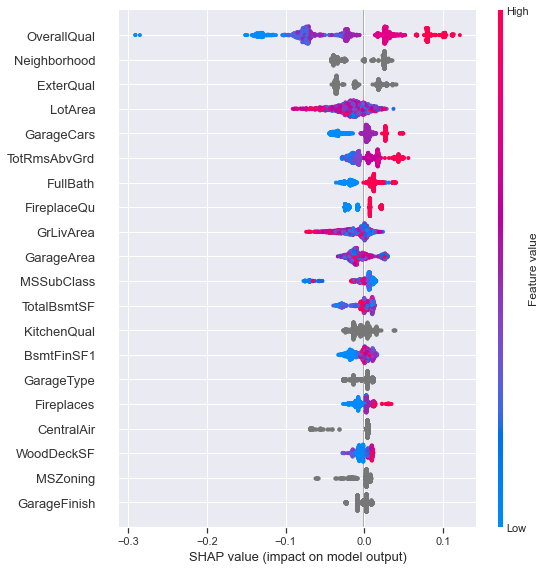

In [25]:
sorted(
    zip(train_X.columns, clf.feature_importances_), 
    key=lambda p: p[1], 
    reverse=True
)

shap_info = clf.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]
shap.summary_plot(shap_values, train_X)

In [26]:
train_X.columns[:12]

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood'],
      dtype='object')

/home/ezrial321/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



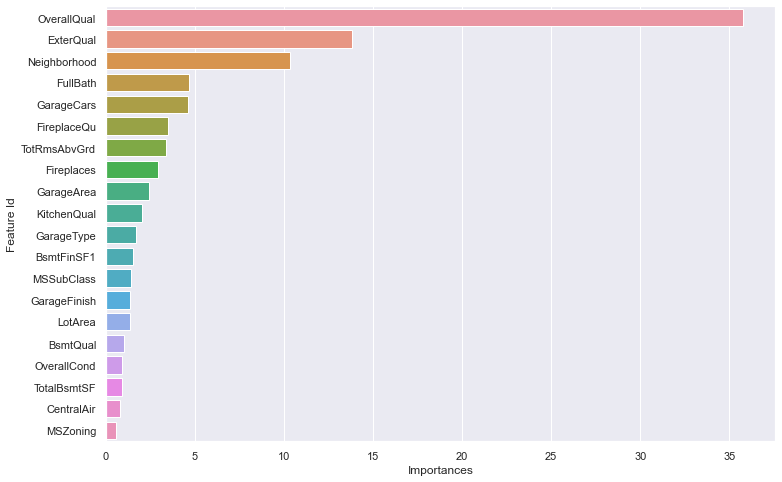

In [27]:
feat_imp = clf.get_feature_importance(prettified=True)
plt.figure(figsize = (12,8))
sns.barplot(feat_imp['Importances'][:20],feat_imp['Feature Id'][:20], orient = 'h')
plt.show()


делаем предсказание

In [28]:
test = test.applymap(str)
pred = clf.predict(test)

XGB boost reggressor

In [29]:

from sklearn.preprocessing import LabelEncoder

str_columns = list(train.select_dtypes(include='object').columns)
print(str_columns)

['MSZoning', 'LotFrontage', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition']


проходимся labelencoder-ом по всем строковым фичам

In [30]:


for col in str_columns:
    label_enc = LabelEncoder()
    label_enc.fit(list(train[col].values))
    train[col] = label_enc.transform(list(train[col].values))
for col in str_columns:
    label_enc = LabelEncoder()
    label_enc.fit(list(test[col].values))
    test[col] = label_enc.transform(list(test[col].values))

In [31]:
train.head()

MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
Id                                                                        
1           60         3           76     8450       1      0         3   
2           20         3           91     9600       1      0         3   
3           60         3           79    11250       1      0         0   
4           70         3           71     9550       1      0         0   
5           60         3           95    14260       1      0         0   

    LandContour  Utilities  LotConfig  ...  PoolArea  PoolQC  Fence  \
Id                                     ...                            
1             3          0          4  ...         0       0      1   
2             3          0          2  ...         0       0      1   
3             3          0          4  ...         0       0      1   
4             3          0          0  ...         0       0      1   
5             3          0          2  ...         0       0      1   

    MiscFeature  MiscVal  MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                                            
1             1        0       2    2008         8              4  12.247694  
2             1        0       5    2007         8              4  12.109011  
3             1        0       9    2008         8              4  12.317167  
4             1        0       2    2006         8              0  11.849398  
5             1        0      12    2008         8              4  12.429216  

[5 rows x 80 columns]

In [32]:
test.head()

MSSubClass  MSZoning  LotFrontage LotArea  Street Alley  LotShape  \
Id                                                                       
1461         20         2           96   11622       1     0         3   
1462         20         3           97   14267       1     0         0   
1463         60         3           90   13830       1     0         0   
1464         60         3           94    9978       1     0         0   
1465        120         3           59    5005       1     0         0   

      LandContour  Utilities  LotConfig  ...  ScreenPorch  PoolArea  PoolQC  \
Id                                       ...                                  
1461            3          0          4  ...          120         0       0   
1462            3          0          0  ...            0         0       0   
1463            3          0          4  ...            0         0       0   
1464            3          0          4  ...            0         0       0   
1465            1          0          4  ...          144         0       0   

      Fence  MiscFeature  MiscVal MoSold YrSold SaleType SaleCondition  
Id                                                                      
1461      1            1        0      6   2010        8             4  
1462      1            0    12500      6   2010        8             4  
1463      1            1        0      3   2010        8             4  
1464      1            1        0      6   2010        8             4  
1465      1            1        0      1   2010        8             4  

[5 rows x 79 columns]

In [33]:
train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    train.drop(columns=['SalePrice']),
    train['SalePrice'],
    test_size=0.20,
    # stratify=train_df_no_missing['SalePrice'],
    random_state=2021
)

In [34]:
import xgboost as xgb


In [42]:
XGB = xgb.XGBRegressor(max_depth=5,learning_rate=0.1,n_estimators=1000,reg_alpha=0.001,reg_lambda=0.000001,n_jobs=-1,min_child_weight=3)
XGB.fit(train_X,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0.001, reg_lambda=1e-06, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
print ("Training score:",XGB.score(train_X,train_y),"Test Score:",XGB.score(val_X,val_y))


Training score: 0.9999814352773584 Test Score: 0.9135006587323575


In [44]:
XGB_pred = np.exp(XGB.predict(test.applymap(float)))

XGBRegressor показывает большую точность на тестовой выборке 

In [ ]:
отправляем решение на кагл - 

In [45]:
submission = pd.DataFrame()
sample_submission = pd.read_csv('input/sample_submission.csv',header = 0)
submission['Id'] = sample_submission.Id
submission['SalePrice'] = XGB_pred
submission.to_csv('submission.csv', index=False)
submission.head(5)

Id      SalePrice
0  1461  124449.125000
1  1462  160962.546875
2  1463  185561.328125
3  1464  193169.015625
4  1465  177874.218750

In [46]:
# !kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m 'first try'

100%|██████████████████████████████████████| 21.2k/21.2k [00:03<00:00, 6.26kB/s]
403 - Forbidden


![title](img/score.png)